# Mean field Floquet dynamics



We introduce the position-momentum conjugate and effective Planck constant $1/N$ the Schroedinger equation becomes-
$$\frac{i}{N} \frac{\partial}{\partial t}\psi_t(q) = \mathcal{H}\psi_t(q)$$
Where hamiltonian 
$$H = -2q^2 -h(t)\sqrt{(1-4q^2)}cos(p)$$
Now we want to find one cycle evolution for Floquet matrix.
The initial condition for wave function is a unitary matrix of which each column is the nth state's initial condition. This means we have to descretize the position as well as momentum space with descrete Hamiltonian.
<br> The position space spans as-
$$
q = (q_0, q_1,q_2,....,q_{N-1})
$$
And momentum is related with position as-
$$
p = \frac{i}{N}\frac{\partial}{\partial q}
$$
So we can write-
$$ \mathcal{H} {|\psi\rangle} = \frac{i}{N}\frac{\partial{|\psi\rangle}}{\partial t}$$
Here the wavefunction-
$$
|\psi \rangle = \left(\begin{array}(
|\psi_0 \rangle\\
|\psi_1 \rangle\\
|\psi_2 \rangle\\
..\\
..\\
|\psi_{N-1} \rangle
\end{array}\right)
$$

Now we can write momentum in descerte space with finite difference method as- 
$$
p^n |\psi\rangle = \frac{i^n}{N^n}\frac{\partial ^n}{\partial q ^n}|\psi\rangle \Longrightarrow^{discrete} \sum_{j=0}^{n} (-1)^j C^{n}_{j} |\psi\rangle_{k+(\frac{n}{2}-j)} = \left(p^n |\psi\rangle \right)_k
$$

<br> McLaurent series for cos(p)-
$$
\left(cos(p) |\psi\rangle \right)_k = \sum_{l=0}^{N} \frac{(-1)^l p^{2l}}{2l!} = \sum_{l=0}^{N} \sum_{j=0}^{l} \frac{(-1)^{(l+j)}}{2l!} C^{l}_{j} |\psi\rangle_{k +(l-j)}
$$

<br> Here j,k,l are integers only.
Now,
$$
\left(\mathcal{H}|\psi\rangle \right)_k = \widetilde{H}_{km} \psi_m
$$
here $C^{n}_{j}$ is for binomial combination.

References:
[1] Check T. Mori's paper equation (12)

## Attention !!!
<br> The $\cos(p)\psi$ term in discrete form already contains $\psi$ term. So I have omitted the "floq_jac" function and incorporated the ordinary differential equation according to Python3's "odeintw" module.
<br> Here in the Hamiltonian the term "q" ranges in  [-0.5,0.5]. We have fixed the frequency($\omega$) so that the whole calculation remains confinded in a single Brillouine zone. So we vary the amplitude of the symmetry breaking field (h) so that we can get a plot of variation of phasefunction vs $(4h/\omega)$

### Change 1 of 2 ....
Check the comment at the top of code bellow.

time taken 35.92824602127075


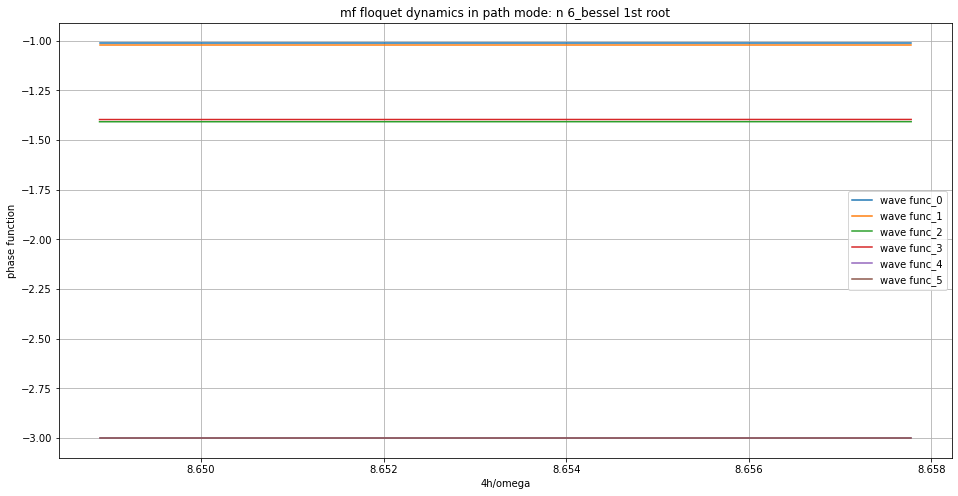

In [17]:
## q,cosp are both taken one by one and hamiltonian is calculated



import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import time
import math

start = time.time()
   
N = 6
h0 = 0.1 
tsteps = 100                        # number of increment in time
hsteps = 300                        # number of increment in h
hs = np.linspace(97.3,97.4,hsteps)
hbessel = 97.35443902
hs = np.sort(np.hstack((hs,hbessel)))
qs = np.linspace(-0.5, 0.5, N)
omega = 45.0
w = omega
T = 2 * np.pi/w                            
t = np.linspace(0,T,tsteps)

psi = np.eye(N) + 1j * np.zeros((N,N))
#psi = np.sqrt(N)*(np.ones((N,N)) + 1j * np.zeros((N,N)))
cosps = np.zeros((N,N)) + 1j * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + 1j * np.zeros((N,N))

floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 1st root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel1.jpeg"

sig_x = np.array([[1,0],[0,1]])
sig_z = np.array([[0,-1j],[1j,0]])

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))

#def floq_jac(psi0,t,h,h0,w,cosp):
def floq_func(psi0,t,h,h0,w,cosp,q):
    drive = h0  + h * np.cos(w * t)
    jac = (-1j) * N * (-2.0 * q * q * psi0 - drive * np.sqrt(1.0 - 4.0 * q * q) * cosp)
    return jac

#def floq_func(psi0,t,h,h0,w,cosp):
#    return np.dot(floq_jac(psi0,t,h0,h,w,cosp), psi0)

def binomial(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in np.arange(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok

if __name__ == '__main__':   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          binomial(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosps[k,m] = cospinit
            cospinit = 0.0
    
    plt.figure(figsize = (16,8))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")        
    
    for nn in np.arange(N):                     # nn will decide the initial wavefunction
        labelname = 'wave func_' + str(nn)
        filename = str(N) + '_wave_' + str(nn)+".txt"
        
        # calculate for first "h"
        h = hs[0]
        
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]  
            cosp = cosps[mm]
            q = qs[mm]
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q))
            floqEvolution_mat[mm] = psi_t[tsteps-1]
        
        evals, evecs = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
        phasefunc = (1j * np.log(evals[nn]))/T
        evecs_path = evecs[nn]               
        phasefunc_path[0] = phasefunc.real
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]):   
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = periodic_psi[mm] 
                cosp = cosps[mm]
                q = qs[mm]
                psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,q))
                floqEvolution_mat[mm] = psi_t[tsteps-1] 
            evals, evecs = eig(floqEvolution_mat)
            evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs)))
            for i,pr in enumerate(prob):
                if (pr.real == np.max(prob.real)):
                    pp = i
                    break
            evecs_path = evecs[pp]
            phasefunc = (1j * np.log(evals[pp]))/T
            phasefunc_path[cc+1] = phasefunc.real                
    

        plt.plot(4*hs/w,phasefunc_path,label = labelname)
        #plt.scatter(4*hs/w,phasefunc_path,color='black', marker='.')
        plt.legend()
    plt.grid()
    print('time taken',time.time()-start)
    plt.show()

### Change 2 of 2 ....
Check the comment at the top of code bellow.

time taken 113.58761596679688


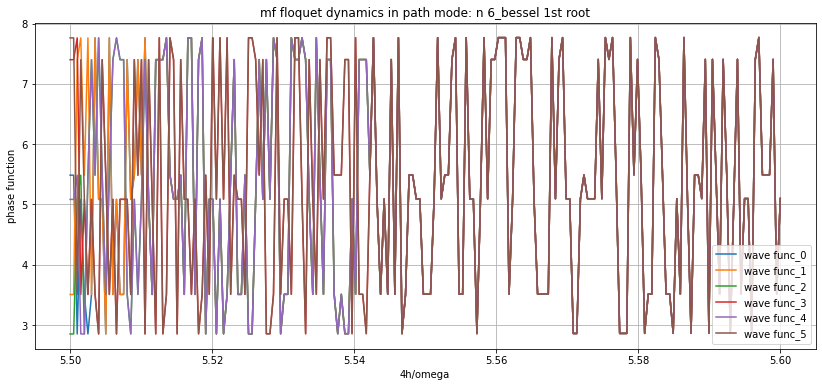

In [13]:
## cosp is taken one by one comumn and the q's are all taken in summation to get the Hamiltoian

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import time
import math

start = time.time()
   
N = 6
h0 = 0.1 
tsteps = 200                        # number of increment in time
hsteps = 500                        # number of increment in h
hss = np.linspace(55.0,56.0,tsteps)
hbssl = 55.20078
hs = np.sort(np.hstack((hss,hbssl)))
qs = np.linspace(-0.5, 0.5, N)
omega = 40.0
w = omega
T = 2 * np.pi/w                            
t = np.linspace(0,T,tsteps)

psi = np.eye(N) + 1j * np.zeros((N,N))
#psi = np.sqrt(N)*(np.ones((N,N)) + 1j * np.zeros((N,N)))
cospsi = np.zeros((N,N)) + 1j * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + 1j * np.zeros((N,N))

floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 1st root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel1.jpeg"

sig_x = np.array([[1,0],[0,1]])
sig_z = np.array([[0,-1j],[1j,0]])

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))

def floq_func(psi0,t,h,h0,w,cosp):
    drive = h0  + h * np.cos(w * t)
    jac = np.zeros(N) + 1j * np.zeros(N)
    for iii in qs:
        jacc =(-1j) * N * (-2.0 * iii * iii * psi0 - drive * np.sqrt(1.0 - 4.0 * iii * iii) * cosp)
        jac = jac + jacc
    return jac

def binomial(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in np.arange(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok

if __name__ == '__main__':   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          binomial(l,j)* periodic_psi[(k+(l-j),(m))]])
            cospsi[k,m] = cospinit
            cospinit = 0.0
    
    plt.figure(figsize = (14,6))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")        
    
    for nn in np.arange(N):                     # nn will decide the initial wavefunction
        labelname = 'wave func_' + str(nn)
        
        # calculate for first "h"
        h = hs[0]
        
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]  
            cosp = cospsi[mm]
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp))
            floqEvolution_mat[mm] = psi_t[tsteps-1]
        
        evals, evecs = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
        phasefunc = (1j * np.log(evals[nn]))/T
        evecs_path = evecs[nn]               
        phasefunc_path[0] = phasefunc.real
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]):   
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = periodic_psi[mm] 
                cosp = cospsi[mm]
                psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp))
                floqEvolution_mat[mm] = psi_t[tsteps-1] 
            evals, evecs = eig(floqEvolution_mat)
            evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs)))
            
            for i,pr in enumerate(prob):
                if (pr.real == np.max(prob.real)):
                    pp = i
                    break
            evecs_path = evecs[pp]
            phasefunc = (1j * np.log(evals[pp]))/T
            phasefunc_path[cc+1] = phasefunc.real                
    

        plt.plot(4*hs/w,phasefunc_path,label = labelname)
        #plt.scatter(4*hs/w,phasefunc_path,color='black', marker='.')
        plt.legend()
    plt.grid()
    print('time taken',time.time()-start)
    plt.show()

#### Try to introduce the path of floquet state in such a way that the phasefunction flows only through the state (it may not be states by consequitive frequencies) where the star product of eigen fucntion of the floquet evolution matrix is "unity" or closest to unity.

time taken 242.96075010299683


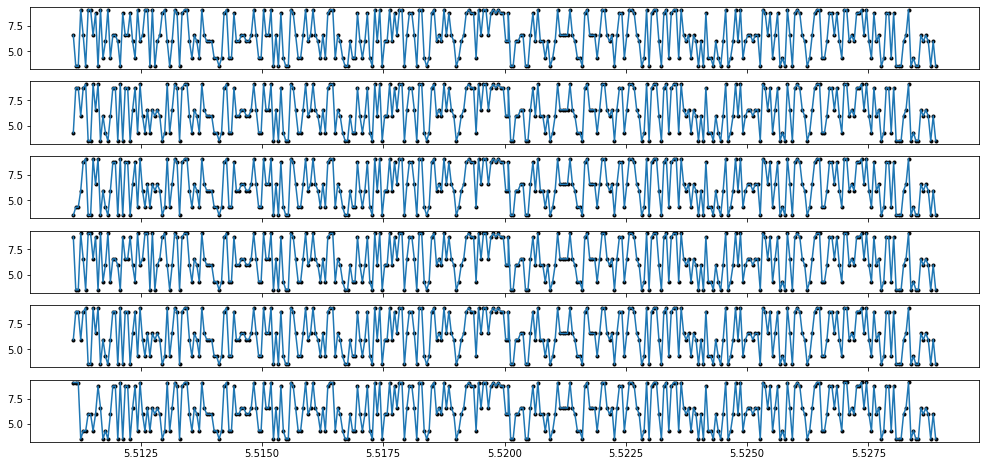

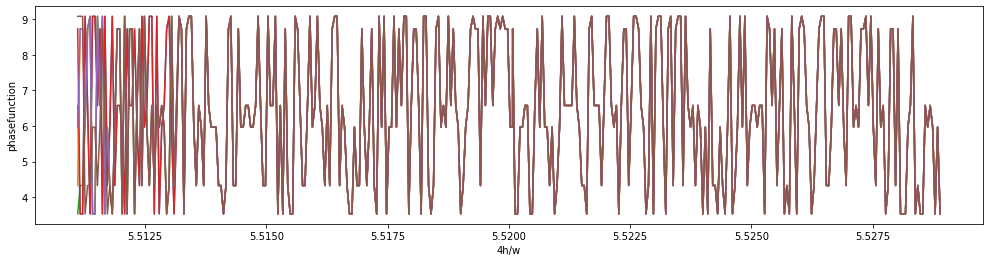

In [14]:
## cosp is taken one by one comumn and the q's are all taken in summation to get the Hamiltoian

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import time
import math

start = time.time()
   
N = 6
h0 = 0.1 
tsteps = 300                        # number of increment in time
hsteps = 350                        # number of increment in h
hss = np.linspace(62.0,62.2,hsteps)
hbssl = 62.10087874
hs = np.sort(np.hstack((hss,hbssl)))
qs = np.linspace(-0.5, 0.5, N)
omega = 45.0
w = omega
T = 2 * np.pi/w                            
t = np.linspace(0,T,tsteps)

psi = np.eye(N) + 1j * np.zeros((N,N))
#psi = np.sqrt(N)*(np.ones((N,N)) + 1j * np.zeros((N,N)))
cospsi = np.zeros((N,N)) + 1j * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + 1j * np.zeros((N,N))

floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
phasefunc_path, ww = [], []
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 1st root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel1.jpeg"

sig_x = np.array([[1,0],[0,1]])
sig_z = np.array([[0,-1j],[1j,0]])

fig, axs = plt.subplots(N, 1, sharex='col', figsize=(17,8))
fig, axs1 = plt.subplots(1, 1, sharex='col', figsize=(17,4))

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))

def floq_func(psi0,t,h,h0,w,cosp):
    drive = h0  + h * np.cos(w * t)
    jac = np.zeros(N) + 1j * np.zeros(N)
    for iii in qs:
        jacc =(-1j) * N * (np.dot(-2.0 * iii * iii, psi0) - np.dot(drive * np.sqrt(1.0 - 4.0 * iii * iii) , cosp))
        jac = jac + jacc
    return jac

def binomial(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in np.arange(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok

if __name__ == '__main__':   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          binomial(l,j)* periodic_psi[(k+(l-j),(m))]])
            cospsi[k,m] = cospinit
            cospinit = 0.0       
    
    for nn in np.arange(N):                     # nn will decide the initial wavefunction
        labelname = 'wave func_' + str(nn)
        
        # calculate for first "h"
        h = hs[0]
        
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]  
            cosp = cospsi[mm]
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp))
            floqEvolution_mat[mm] = psi_t[tsteps-1]
        
        evals, evecs0 = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs0)))
        phasefunc = (1j * np.log(evals[nn]))/T
        evecs_path = evecs[nn]
        phasefunc_path.append(phasefunc.real)
        ww.append(hs[0])
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]): 
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = periodic_psi[mm] 
                cosp = cospsi[mm]
                psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp))
                floqEvolution_mat[mm] = psi_t[tsteps-1] 
            evals, evecs0 = eig(floqEvolution_mat)
            evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs0)))
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs)))
            for i,pr in enumerate(prob):
                if (pr.real == np.max(prob.real)):
                    pp = i
                    evecs_path = evecs[pp]
                    phasefunc = (1j * np.log(evals[pp]))/T
                    phasefunc_path.append(phasefunc.real)
                    ww.append(h)
                    break
    
        axs[nn].plot(4*np.sort(np.asarray(ww))/w,phasefunc_path,label = labelname)
        axs[nn].scatter(4*np.sort(np.asarray(ww))/w,phasefunc_path,color='black', marker='.')
        axs1.plot(4*np.sort(np.asarray(ww))/w,phasefunc_path,label = labelname)
        axs1.set_xlabel("4h/w")
        axs1.set_ylabel("phasefunction")
        phasefunc_path,ww = [],[]
    print('time taken',time.time()-start)

### Scatter plot


#### We have tried to plot all the available eigen values i.e. phasefunctions for each (4 Amplitude/ frequency).
Keeping in mind that we have to work inside a single brillouin zone we have fixed the frequency(omega) and varied the amplitude(h).

running for N =  10 with 2 processors
time taken 83.3774185180664 sec


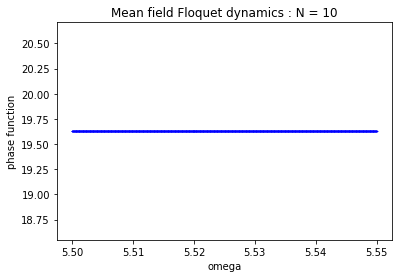

In [4]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time


N = 10
h0 = 0.1    
qs = np.linspace(-0.5, 0.5, N)
omega = 40.0
w = omega
tsteps = 500
hsteps = 1000
hss = np.linspace(55.0,55.5,hsteps)
bessel = 55.20078
hs = np.hstack((hss,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cospsik = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "Mean field Floquet dynamics : N =" + str(N)

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))

def floq_func(psi0,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac_psi = np.zeros(N) + 1j * np.zeros(N)
    for q in qs:
        jacc_psi = (-1j) *N* (-2.0 * q * q * psi0  - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
        jac_psi = jac_psi + jacc_psi
    return jac_psi

def floq_evolv(periodic_psi,hs,h0,w,cospik):
    T = 2 * np.pi/w                                             ## time periode
    t = np.linspace(0,2 * np.pi/w,tsteps)                       ## time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for m in np.arange(N):
        cosp = cospsik[m]
        psi0 = periodic_psi[m]
        h = hs[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp))
        floqEvoluion_mat[m] = psi_t[tsteps-1]                ## do it here
    
    evals, evecs = eig(floqEvoluion_mat)
    #evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs0)))    
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
        
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cospsik[k,m] = cospinit
            cospinit = 0.0
    
    
    data = p.starmap(floq_evolv,[(periodic_psi,hs,h0,w,cospsik) for h in hs])
    
    print("time taken",time.time()-start,"sec")
    
    for xx in np.arange(len(hs)):
        plt.scatter(4*hs[xx]/omega * np.ones(N), data[xx].real, color='blue', marker='.', s= 0.2)
    plt.title("Mean field Floquet dynamics : N = 10")    
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.show()

# With new Hamiltonian ( updated by AR sir in his latest github repos)

### Mean field Floquet dynamics
Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& -\frac{1}{2N}\sum_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}

Here, we have $N$ spin-$1/2$ particles in a $1-$dimensional lattice, and $i,j$ are site indices. We will now attempt a numerical evaluation of
the Floquet eigenspectrum of this system.

First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $S^2=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$, where

\begin{equation}
\vec{S}=S^x\hat{x}+S^y\hat{y}+S^z\hat{z}\equiv \sum_i \vec{\sigma}_i.
\end{equation}

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{multline}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  \\
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{multline}

Note that, since the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{1}{2N}(S^z)^2 - h_0\cos{(\omega t )}S^x$, the matrix elements of
\begin{eqnarray}
\left(H_0\right)_{ij} &=& -\frac{N}{2} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &=& \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  \\
    & &                     +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{eqnarray}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

\begin{eqnarray}
\left(h\right)_{ij} &\approx& -\frac{1}{2} s^2_i \delta_{ij},\nonumber\\
h_0 &\rightarrow& -\frac{1}{2}s^2\\
\left(h_1\right)_{ij} &\approx& \frac{1}{2}\sqrt{\frac{1}{4} - s^2_i}\left[\delta_{i+1, j}  + \delta_{i-1,j}\right]\\
h_1 &\rightarrow& \sqrt{\frac{1}{4} - s^2_i}\;\;\cos{p},
\end{eqnarray}
where we have expanded the matrix elements in a basis of $e^{ipx}$. In this limit, we obtain the Lipkin Model (Insert from previous notebook)
.


References:

[1] Check T. Mori's paper equation (12)

#### The code below here is no "GPU" code

In [ ]:
# scatter plot



#  THIS CODE IS DONE FOR NEWER HAMILTONIAN. THE QUASI-ENREGY ARE PLOTTED WITH SCATTER PLOT I.E. WE HAVE PLOTTED
#  ALL THE QUASI-ENERGIES IN A SCATTER PLOT FOR EACH "h". THIS WORKS ARE FOLLOWS. WE HAVE TAKEN EACH OF CHOSEN
#  h FROM "hs" AND THEN WE CALCUALTED "N" NUMBER OF QUASI-ENERGIS FOR A SPIN SYSTEM CONSISTED OF "N" NUMBER OF 
#  1D SPIN.


import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

N = 4 
h0 = 0.1
omega = 40.0
w = omega
tsteps = 1000
hsteps = 1000
hs = np.linspace(20.0,27.1,hsteps)
ampp = (np.ones((N,len(hs)))*hs).T
psi = np.eye(N) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "Mean field Floquet dynamics : N =" + str(N)
filename = 'mfd_fl_'+str(N) +'imag.jpeg'
filename1 = 'mfd_fl_'+str(N) +'real.jpeg'

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
def posetive_extractor(x):
    for i in np.arange(len(x)):
        if x[i]<0:
            x[i] = 0
    return x

def inf_reducer(x):
    for i in np.arange(len(x)):
        if x[i] == -math.inf:
            x[i] = 0.0
        if x[i] == math.inf:
            x[i] = 0.0
    return x

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    #print('h0',h0,'h',h,'w',w)
    jac = - 1j * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w                                             ## time periode
    t = np.linspace(0,2 * np.pi/w,tsteps)                       ## time range
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for m in np.arange(N):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]                
    
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * inf_reducer(np.log(posetive_extractor(evals))))/T
    #evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs0)))    
    #phasefunc = (1j * np.log(evals))/T
    #phasefunc = - np.angle(evals)/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 1
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       

    s = -0.5 + (1./N) * np.arange(N)
    H0 = np.diagflat(-0.5 * (N * s) ** 2.0)
    
    delta_matrix = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            delta_matrix[i][j] = delta_func(i+1,j) + delta_func(i-1,j)

    H1 = 0.5 * np.sqrt(0.25* N * N - (N * s) ** 2.0) * delta_matrix   
    
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])
    
    print('time taken',time.time()-start,'second')
    
    plt.figure(figsize = (14,6))
    for xx in np.arange(len(hs)):
        plt.scatter(4 * ampp[xx]/omega,np.asarray(data[xx]).imag, color = 'blue', marker='.', s = 0.2)
        #plt.scatter(4 * ampp[xx]/omega,np.asarray(data[xx]).real, color = 'red', marker='.', s = 0.2)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.savefig(filename, dpi=400)
    plt.show()

running for N =  4 with 1 processors
time taken 14.164283752441406 second


time taken 54.89882707595825 sec


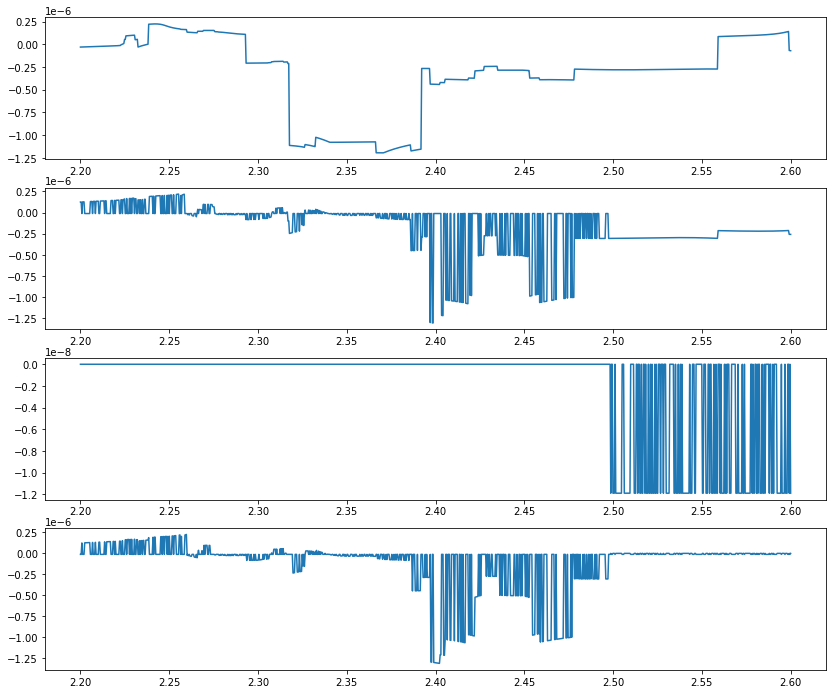

In [6]:
# specific phase function path


#   NOW WE GIVE A TRY TO PLOT QUASI ENERGIES FOR A SPECIFIC PATH.
#   ACCORDING TO FLOQUET THEORY, AN  N X N UNITARY MATRIX IS CHOSEN INITIALLY, LETS CALL IT "S" MATRIX. EACH OF THE COLOUM
#   OF S MATRIX IS TAKEN AS THE INITIAL WAVE FUNCTION FOR EVOLVE. AFTER ONE PERIOD OF EVOLUTION WE GET AN N X 1 DIMENSIONAL
#   MATRIX WHICH IS THE WAVE FUNCITON DENOTING STATE OF THE SPIN SYSTEM AFTER ONE TIME PERIOD. SIMILAR WAY WE COLLECT ALL
#   OTHER "N" OF WAVE FUNCIOTN EACH WHICH IS BASICALLY COLUMN MATRIX. WE THEN BUILD ANOTHER N X N MATRIX.
#   LETS CALL THIS MATRIX AS "U" MATRIX. THE EIGEN FUNCTION OF U MATRIX 

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time() 

N = 4
h0 = 0.1
omega = 40.0
w = omega
tsteps = 1000
hsteps = 1000
T = 2 * np.pi/w
t = np.linspace(0,T,tsteps)

hs = np.linspace(22,26,hsteps)
ampp = (np.ones((N,len(hs)))*hs).T
psi = np.eye(N) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))

#plt.figure(figsize = (16,8))
title = "Mean field Floquet dynamics : N =" + str(N)
#fig, axs = plt.subplots(N, 1, sharex='col', figsize=(14,12))
fig, axs = plt.subplots(N, figsize=(14,12))

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    #print('h0',h0,'h',h,'w',w)
    jac = -1j * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h
    
if __name__ == '__main__':     

    s = -0.5 + (1./N) * np.arange(N)
    H0 = np.diagflat(-0.5 * (N * s) ** 2.0)
    
    delta_matrix = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            delta_matrix[i][j] = delta_func(i+1,j) + delta_func(i-1,j)

    H1 = 0.5 * np.sqrt(0.25 * N * N - (N * s) ** 2.0) * delta_matrix   
    
    for nn in np.arange(N):                     # nn will decide the initial wavefunction
        labelname = 'wave func_' + str(nn)
        filename = str(N) + '_wave_' + str(nn)+ '.txt'
        
        # calculate for first "h"
        h = hs[0]           
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
        for mm in np.arange(N):
            psi0 = psi[mm]  
            psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[-1]         
        evals, evecs = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
        phasefunc = (1j * np.log(evals[nn]))/T
        #phasefunc = - np.angle(evals[nn])/T
        evecs_path = evecs[nn]               
        phasefunc_path[0] = phasefunc.imag
    
        # calculate for rest of the "h"
        for cc, h in enumerate(hs[1:len(hs)]):   
            floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
            for mm in np.arange(N):
                psi0 = psi[mm]  
                psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
                floqEvolution_mat[mm] = psi_t[-1] 
            evals, evecs = eig(floqEvolution_mat)
            evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
            prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs)))
            for i,pr in enumerate(prob):
                if (round(pr.real) == 1.0):
                    pp = i
                    break
            evecs_path = evecs[pp]
            phasefunc = (1j * np.log(evals[pp]))/T
            phasefunc_path[cc+1] = phasefunc.imag
        axs[nn].plot(4*hs/w,phasefunc_path)
    print('time taken',time.time()-start,'sec')